# Is That a Supra? <br>
## 불면증때문에 술마셨는데 취해서만드는 Supra Classifier <br>
### Is that a Supra? 란?
외국 밈(meme) 중 Supra라는 차량을 발견하면 Is that a Supra? 라고 하는것에서 착안함. <a href="https://www.youtube.com/watch?v=ybZmYvaqwEg">youtube 영상</a>

## * 이미지 크롤링 <br>
### 신경망은 ResNet50을 사용할 것이기 때문에 그렇다 해도 일단 Supra이미지를 구글 이미지에서 가져와야한다. <br>

고마워요 <a href="https://blog.naver.com/fkdldjs60/222161730266">인터넷!</a>

In [1]:
from urllib.request import urlretrieve
from urllib.parse import quote_plus
from urllib.error import HTTPError
import urllib
from selenium import webdriver
import time
import socket
import os


def crawler(search, num_img=300, img_format="jpg", timeout=30):
    url = f'https://www.google.com/search?q={quote_plus(search)}&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiYz_K9kfPtAhXQfd4KHQQoDxEQ_AUoAXoECAYQAw'

    driver = webdriver.Chrome()
    driver.get(url)
    driver.maximize_window()

    # Scrolling
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight)")
        time.sleep(1)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            try:
                driver.find_element_by_css_selector(".mye4qd").click()
            except:
                break
        last_height = new_height

    os.makedirs(search, exist_ok=True)

    images = driver.find_elements_by_css_selector(".rg_i.Q4LuWd")
    print(len(images))
    count = 1

    # Download images.
    for image in images:
        try:
            driver.execute_script("arguments[0].click();", image)
            time.sleep(2)
            imgUrl = driver.find_element_by_xpath(
                '//*[@id="Sva75c"]/div/div/div[3]/div[2]/c-wiz/div[1]/div[1]/div/div[2]/a/img').get_attribute("src")
            opener = urllib.request.build_opener()
            opener.addheaders = [('User-agent',
                                  'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36')]
            urllib.request.install_opener(opener)
            try:
                socket.setdefaulttimeout(timeout)
                urllib.request.urlretrieve(imgUrl, search + "/" + str(count) + '.' + img_format)
            except socket.timeout:
                print("Request timed out.")
                pass

            print(str(count) + "th image is downloaded.")
            count = count + 1
            if count == num_img + 1:
                break
        except HTTPError:
            print("Http response not good.")
            pass




In [1]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import pathlib
import glob

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# 이미지 format 맞춰주기
def format_convert():
    for file in glob.glob("./data/*/*.jpeg"):
        im = Image.open(file)
        rgb_im = im.convert('RGB')
        rgb_im.save(file.replace("jpeg", "jpg"), quality=95)
        im.close()
        os.remove(file)

In [3]:
os.environ["TF_FROCE_GPU_ALLOW_GROWTH"] = "true"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [36]:
# 데이터셋을 불러온다.
data_dir = "./data"
data_dir = pathlib.Path(data_dir)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir, label_mode="binary", class_names=['0', '1'],
    batch_size=16,
    image_size=(256, 256), seed=1, validation_split=0.2, subset="training"
)

val_ds = images = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir, label_mode="binary", class_names=['0', '1'],
    batch_size=16,
    image_size=(256, 256), seed=1, validation_split=0.2, subset="validation"
)

Found 942 files belonging to 2 classes.
Using 754 files for training.
Found 942 files belonging to 2 classes.
Using 188 files for validation.


In [6]:
# batch shape
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 256, 256, 3)
(16, 1)


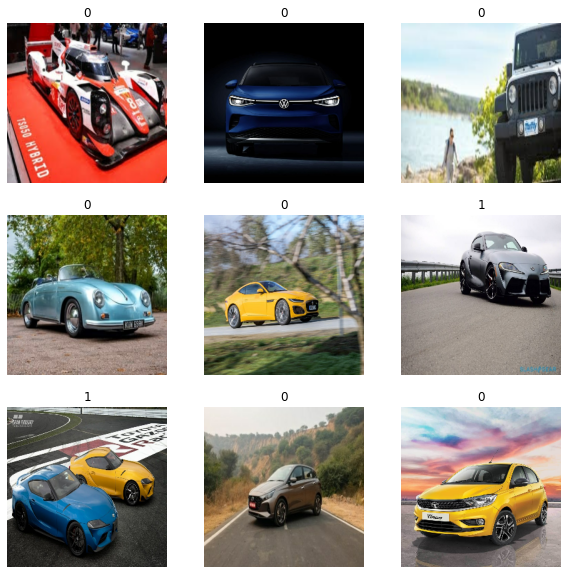

In [15]:
# 데이터 시각화
# 우리의 Supra는 1, 나머지는 0이다. 물론 신뢰성은 떨어진다. 그냥 Supra로 검색된 결과와 Car photo로 검색된결과 기준으로 나눴다.
# 보다보면 본넷사진인데 1인경우가 있더라. 이러니 성능이 안나오지싶다.
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
### import modules.
from keras.applications import ResNet50
from keras.layers import Dense, Input, Activation, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
import numpy as np

In [21]:
# Andrew Ng 수업에서 배웠던 ResNet50을 불러와서 tranfer learning을 할 생각이었다.
# 복잡하게 추가할 실력이 안되니 출력부분만 바꿔주자.
def model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3), pooling='max', classes=2)
    base_model.trainable = False
    x = base_model.output
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(base_model.input, x)
    
    return model

In [22]:
my_model = model()

In [23]:
my_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [26]:
my_model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [27]:
history = my_model.fit(
    train_ds, validation_data=val_ds, epochs=30
)

Epoch 1/30
48/48 [==============================] - 13s 141ms/step - loss: 0.7326 - accuracy: 0.6560 - val_loss: 1.2620 - val_accuracy: 0.7819
Epoch 2/30
48/48 [==============================] - 2s 51ms/step - loss: 0.3314 - accuracy: 0.8407 - val_loss: 1.1639 - val_accuracy: 0.7606
Epoch 3/30
48/48 [==============================] - 2s 51ms/step - loss: 0.2269 - accuracy: 0.9140 - val_loss: 0.9875 - val_accuracy: 0.7926
Epoch 4/30
48/48 [==============================] - 2s 51ms/step - loss: 0.1821 - accuracy: 0.9279 - val_loss: 1.2893 - val_accuracy: 0.7766
Epoch 5/30
48/48 [==============================] - 2s 52ms/step - loss: 0.1060 - accuracy: 0.9669 - val_loss: 0.8175 - val_accuracy: 0.7553
Epoch 6/30
48/48 [==============================] - 2s 51ms/step - loss: 0.1149 - accuracy: 0.9456 - val_loss: 1.8222 - val_accuracy: 0.6170
Epoch 7/30
48/48 [==============================] - 2s 52ms/step - loss: 0.0811 - accuracy: 0.9680 - val_loss: 0.8083 - val_accuracy: 0.7606
Epoch 8/30


In [28]:
# 이제 metrics를 시각화 하자.
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

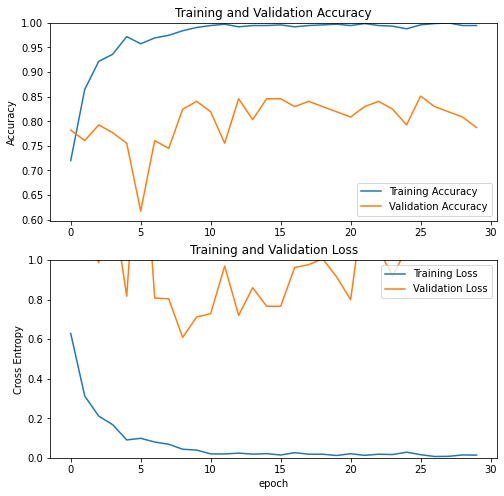

In [29]:
plot_metrics(history)

In [31]:
# validation set을 원래 이렇게 쓰는건 아니지만 일단 이렇게 써보았다. 처참하다.
for img, labels in val_ds.take(1):
    print(my_model.predict(img) > 0.5)
    print(labels == 1)

[[False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]
tf.Tensor(
[[False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]], shape=(16, 1), dtype=bool)


### 위의 그래프를 본다면 매우 아름답게 overfitting이 되어있음을 알 수 있다.<br>
<span> 아마도 데이터는 적고 ResNet50이 워낙 으마으마하기 때문인거같다.</span><br>
<span> Andrew Ng교수님께서 overfitting일 땐 unit을 줄이거나 데이터를 늘려보라 하였다.</span>
<span> 모델수정은 귀찮으니 데이터를 늘려보았다.</span>

## * Data augmentation <br>
#### 데이터를 회전, 뒤틀기 등등... 적용하여 데이터의 수를 늘려준다.
#### 데이터가 적어서 Data augmetation을 하여 데이터를 늘려주었다. <span stlye="font-weight: bold">그러나 augmentation하니 성능이 거지가되었다?</span>
아래 그래프를 본다면 <a href="https://lh3.googleusercontent.com/proxy/zoMl32kYy-Nie_KAXrrV2Jm0IRDs3t688k8kYnUkZ106HyXB3XbBzhVj_A5dsRiEOeDx-AJrlpZKbuk4DDy7Aqbh8JfRKo7-08BY0no4-tZtELkqRatPQV_jpd1NiCnOSDv7pYD4AlM">감탄사가 절로나온다</a>

In [37]:
# 어머 데이터가 부족하네? Augmentaion으로 데이터를 늘려보아요
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
import scipy.ndimage as ndimage

def random_rotate_image(image):
    image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
    return image

def tf_random_rotate_image(image, label):
    im_shape = image.shape
    [image, ] = tf.py_function(random_rotate_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


train_ds = train_ds.map(tf_random_rotate_image)
val_ds = val_ds.map(tf_random_rotate_image)

In [34]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

my_model_aug = model()
my_model_aug.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history_aug = my_model_aug.fit(
    train_ds, validation_data=val_ds, epochs=30
)

Epoch 1/30
48/48 [==============================] - 17s 307ms/step - loss: 0.9207 - accuracy: 0.4992 - val_loss: 2.7190 - val_accuracy: 0.4096
Epoch 2/30
48/48 [==============================] - 3s 53ms/step - loss: 0.6836 - accuracy: 0.6500 - val_loss: 1.0963 - val_accuracy: 0.5372
Epoch 3/30
48/48 [==============================] - 3s 52ms/step - loss: 0.4994 - accuracy: 0.7462 - val_loss: 1.6451 - val_accuracy: 0.5053
Epoch 4/30
48/48 [==============================] - 3s 53ms/step - loss: 0.3922 - accuracy: 0.8068 - val_loss: 1.4780 - val_accuracy: 0.4734
Epoch 5/30
48/48 [==============================] - 3s 55ms/step - loss: 0.3181 - accuracy: 0.8445 - val_loss: 1.9698 - val_accuracy: 0.5479
Epoch 6/30
48/48 [==============================] - 3s 54ms/step - loss: 0.2822 - accuracy: 0.8857 - val_loss: 2.1238 - val_accuracy: 0.6702
Epoch 7/30
48/48 [==============================] - 3s 59ms/step - loss: 0.2671 - accuracy: 0.8962 - val_loss: 2.0573 - val_accuracy: 0.6702
Epoch 8/30


In [97]:
my_model.evaluate(val_ds, batch_size=16)

12/12 [==============================] - 3s 238ms/step - loss: 0.6412 - accuracy: 0.7074


[0.6411649584770203, 0.707446813583374]

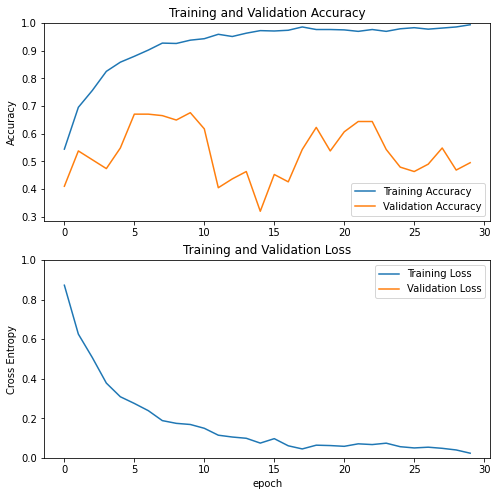

In [39]:
plot_metrics(history_aug)

### 처참하다.
<span>Validation Loss는 너무높아서 하늘을 뚫고 올라가버렸다.</span>
<span>아래는 예측결과이다. 너무 끔찍해서 안본눈을 사고싶을정도.</span>
<span>이번엔 여기까지만하고 다음엔 직접 모델을 쌓아서 작게 만들어볼 생각이다.</span>
<span style="color:red;">이걸 기획한날도 결국 잠을 못이뤘다고한다.</span>

In [41]:
for img, labels in val_ds.take(1):
    print(my_model_aug.predict(img) > 0.5)
    print(labels == 1)

[[ True]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [ True]]
tf.Tensor(
[[False]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [False]], shape=(16, 1), dtype=bool)
